In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import neighbors
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import os
os.getcwd()
os.chdir('/home/ghk829/zillow')
prop_2016 = pd.read_csv('./properties_2016.csv')
train_2016 = pd.read_csv("./train_2016_v2.csv")
prop_2017 = pd.read_csv('./properties_2017.csv')
train_2017 = pd.read_csv('./train_2017.csv')

for c, dtype in zip(prop_2016.columns, prop_2016.dtypes):	
    if dtype == np.float64:		
        prop_2016[c] = prop_2016[c].astype(np.float32)
        
for c, dtype in zip(prop_2017.columns, prop_2017.dtypes):	
    if dtype == np.float64:		
        prop_2017[c] = prop_2017[c].astype(np.float32)
ref_2017=prop_2017[prop_2017.latitude.isnull()].parcelid
na_2017=prop_2016.query('parcelid in @ref_2017')
prop_2017_2=prop_2017[prop_2017.latitude.notnull()].append(na_2017)
# 2016년 데이터 기준
ref_2016=prop_2016[prop_2016.latitude.isnull()].parcelid
na_2016=prop_2017.query('parcelid in @ref_2016')
prop_2016_2=prop_2016[prop_2016.latitude.notnull()].append(na_2016)
df_train = train_2016.merge(prop_2016_2, how='left', on='parcelid')

In [60]:
# train set은 10 11 12월 데이터가 없기 떄문에 row수가 다름

In [61]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 58):
    print(prop_2017.describe())

           parcelid  airconditioningtypeid  architecturalstyletypeid  \
count  2.985217e+06          815362.000000               6061.000000   
mean   1.332586e+07               1.945724                  7.202607   
std    7.909966e+06               3.160507                  2.436291   
min    1.071172e+07               1.000000                  2.000000   
25%    1.164371e+07               1.000000                  7.000000   
50%    1.254509e+07               1.000000                  7.000000   
75%    1.409712e+07               1.000000                  7.000000   
max    1.696019e+08              13.000000                 27.000000   

       basementsqft   bathroomcnt    bedroomcnt  buildingclasstypeid  \
count   1627.000000  2.982260e+06  2.982272e+06         12731.000000   
mean     647.220642  2.216196e+00  3.093362e+00             3.734742   
std      538.787109  1.078250e+00  1.271569e+00             0.500371   
min       20.000000  0.000000e+00  0.000000e+00             1.0

max           4.830301e+14  


In [63]:
prop_2017_2.isnull().sum()

parcelid                              0
airconditioningtypeid           2169478
architecturalstyletypeid        2979156
basementsqft                    2983589
bathroomcnt                          25
bedroomcnt                           13
buildingclasstypeid             2972449
buildingqualitytypeid           1043031
calculatedbathnbr                115941
decktypeid                      2967836
finishedfloor1squarefeet        2781426
calculatedfinishedsquarefeet      42969
finishedsquarefeet12             263965
finishedsquarefeet13            2977545
finishedsquarefeet15            2793373
finishedsquarefeet50            2781426
finishedsquarefeet6             2963733
fips                                  0
fireplacecnt                    2672086
fullbathcnt                      115941
garagecarcnt                    2094074
garagetotalsqft                 2094074
hashottuborspa                  2935152
heatingorsystemtypeid           1115550
latitude                              0


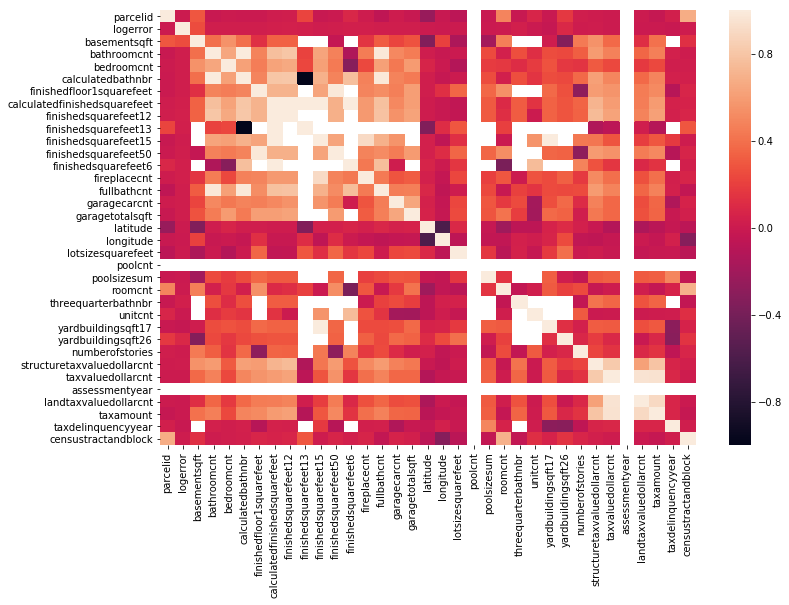

In [66]:
#Identify numerical columns to produce a heatmap
catcols = ['airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid','decktypeid','fips','hashottuborspa','heatingorsystemtypeid','pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid','yearbuilt','taxdelinquencyflag']
numcols = [x for x in df_train.columns if x not in catcols]

#Lets start by plotting a heatmap to determine if any variables are correlated
plt.figure(figsize = (12,8))
sns.heatmap(data=df_train[numcols].corr())
plt.show()
plt.gcf().clear()

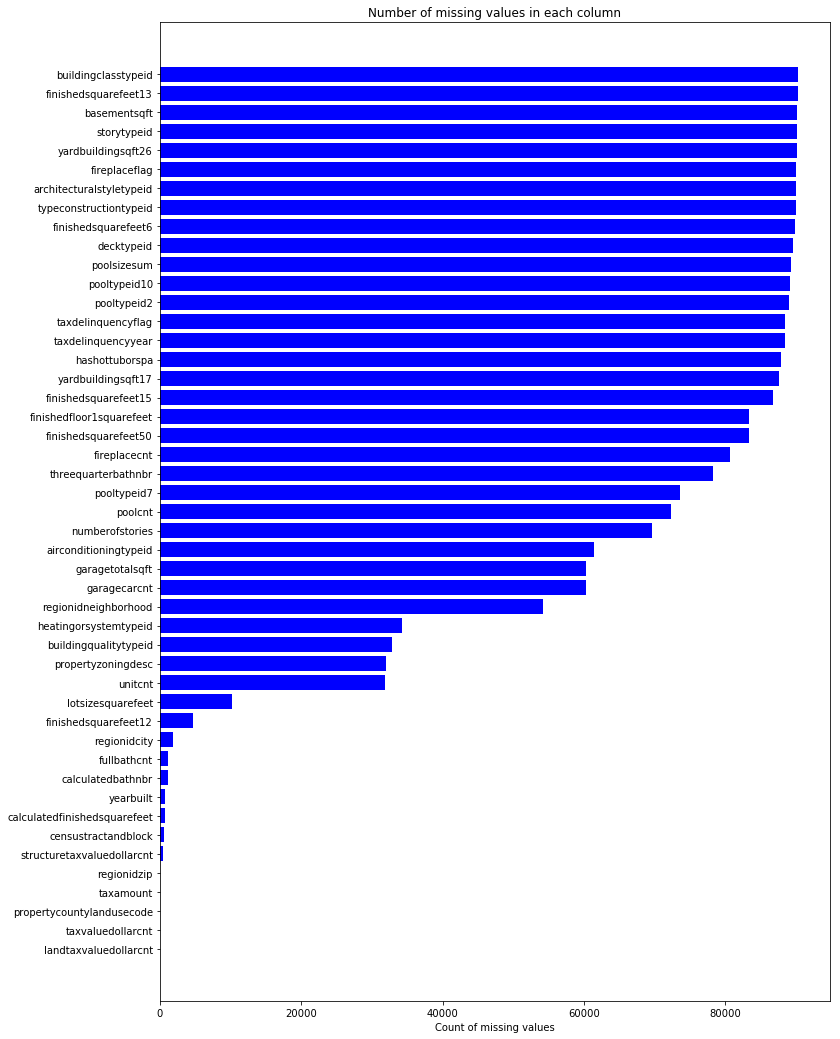

In [67]:
missing_df = df_train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [68]:
#'calculatedfinishedsquarefeet' has the fewest missing values so lets remove the others, note also that except for 'finishedsquarefeet12' the rest have large amount of missing values anyways. 
#Also if you look at my script in https://www.kaggle.com/nikunjm88/creating-additional-features 'calculatedfinishedsquarefeet' appears to be the most important variable
dropcols = ['finishedsquarefeet12','finishedsquarefeet13', 'finishedsquarefeet15','finishedsquarefeet6']

#finishedsquarefeet50 and finishedfloor1squarefeet are the exactly the same information according to the dictionary descriptions, lets remove finishedsquarefeet50 as it has more missing values
dropcols.append('finishedsquarefeet50')

#'bathroomcnt' and 'calculatedbathnbr' and 'fullbathcnt' seem to be the same information aswell according to the dictionary descriptions. Choose 'bathroomcnt' as has no missing values, so remove the other two
dropcols.append('calculatedbathnbr')
dropcols.append('fullbathcnt')


In [69]:
#The below variables are flags and lets assume if they are NA's it means the object does not exist so lets fix this
index = df_train.hashottuborspa.isnull()
df_train.loc[index,'hashottuborspa'] = "None"

# pooltypeid10(does home have a Spa or hot tub) seems to be inconcistent with the 'hashottuborspa' field - these two fields should have the same information I assume?
print(df_train.hashottuborspa.value_counts())
print(df_train.pooltypeid10.value_counts())

#lets remove 'pooltypeid10' as has more missing values
dropcols.append('pooltypeid10')

#Assume if the pooltype id is null then pool/hottub doesnt exist 
index = df_train.pooltypeid2.isnull()
df_train.loc[index,'pooltypeid2'] = 0

index = df_train.pooltypeid7.isnull()
df_train.loc[index,'pooltypeid7'] = 0

index = df_train.poolcnt.isnull()
df_train.loc[index,'poolcnt'] = 0

None    87910
True     2365
Name: hashottuborspa, dtype: int64
1.0    1161
Name: pooltypeid10, dtype: int64


In [70]:
#Theres more missing values in the 'poolsizesum' then in 'poolcnt', Let's fill in median values for poolsizesum where pool count is >0 and missing. I think this is sensible assumption as residential pool sizes are fairly standard size I guess in the U.S.
#Also the poolsizesum doesn't seem to be much of an important variable (https://www.kaggle.com/nikunjm88/creating-additional-features) so imputing with the median hopefully won't cause too much of an issue
print(df_train.poolsizesum.isnull().sum())
print(df_train.poolcnt.value_counts())

#Fill in those properties that have a pool with median pool value
poolsizesum_median = df_train.loc[df_train['poolcnt'] > 0, 'poolsizesum'].median()
df_train.loc[(df_train['poolcnt'] > 0) & (df_train['poolsizesum'].isnull()), 'poolsizesum'] = poolsizesum_median

#If it doesn't have a pool then poolsizesum is 0 by default
df_train.loc[(df_train['poolcnt'] == 0), 'poolsizesum'] = 0

89306
0.0    72374
1.0    17901
Name: poolcnt, dtype: int64


In [71]:
#There seems to be inconsistency between the fireplaceflag and fireplace cnt - my guess is that these should be the same
print(df_train.fireplaceflag.isnull().sum())
print(df_train.fireplacecnt.isnull().sum())

#There seems to be 80668 properties without fireplace according to the 'fireplacecnt' but the 'fireplace flag' says they are 90053 missing values
#Lets instead create the fireplaceflag from scratch using 'fireplacecnt' as there are less missing values here
df_train['fireplaceflag']= "No"
df_train.loc[df_train['fireplacecnt']>0,'fireplaceflag']= "Yes"

index = df_train.fireplacecnt.isnull()
df_train.loc[index,'fireplacecnt'] = 0

#Tax deliquency flag - assume if it is null then doesn't exist
index = df_train.taxdelinquencyflag.isnull()
df_train.loc[index,'taxdelinquencyflag'] = "None"



90053
80668


In [72]:
#Same number of missing values between garage count and garage size - assume this is because when there are properties with no garages then both variables are NA
print(df_train.garagecarcnt.isnull().sum())
print(df_train.garagetotalsqft.isnull().sum())

#Assume if Null in garage count it means there are no garages
index = df_train.garagecarcnt.isnull()
df_train.loc[index,'garagecarcnt'] = 0

#Likewise no garage means the size is 0 by default
index = df_train.garagetotalsqft.isnull()
df_train.loc[index,'garagetotalsqft'] = 0

#Let's fill in some missing values using the most common value for those variables where this might be a sensible approach
#AC Type - Mostly 1's, which corresponds to central AC. Reasonable to assume most other properties are similar.
df_train['airconditioningtypeid'].value_counts()
index = df_train.airconditioningtypeid.isnull()
df_train.loc[index,'airconditioningtypeid'] = 1

60338
60338


In [73]:
#heating or system - Mostly 2, which corresponds to central heating so seems reasonable to assume most other properties have central heating  
print(df_train['heatingorsystemtypeid'].value_counts())
index = df_train.heatingorsystemtypeid.isnull()
df_train.loc[index,'heatingorsystemtypeid'] = 2


2.0     38303
7.0     15519
24.0     1071
6.0       970
20.0       97
13.0       76
18.0       25
1.0        13
14.0        2
10.0        2
11.0        1
12.0        1
Name: heatingorsystemtypeid, dtype: int64


In [74]:
# 'threequarterbathnbr' - not an important variable according to https://www.kaggle.com/nikunjm88/creating-additional-features, so fill with most common value
print(df_train['threequarterbathnbr'].value_counts())
index = df_train.threequarterbathnbr.isnull()
df_train.loc[index,'threequarterbathnbr'] = 1


1.0    11912
2.0       90
3.0        6
4.0        1
Name: threequarterbathnbr, dtype: int64


In [75]:
missingvalues_prop = (df_train.isnull().sum()/len(df_train)).reset_index()
missingvalues_prop.columns = ['field','proportion']
missingvalues_prop = missingvalues_prop.sort_values(by = 'proportion', ascending = False)
print(missingvalues_prop)
missingvaluescols = missingvalues_prop[missingvalues_prop['proportion'] > 0.97].field.tolist()
dropcols = dropcols + missingvaluescols
df_train = df_train.drop(dropcols, axis=1)


                           field  proportion
8            buildingclasstypeid    0.999823
15          finishedsquarefeet13    0.999634
5                   basementsqft    0.999524
43                   storytypeid    0.999524
48            yardbuildingsqft26    0.998948
4       architecturalstyletypeid    0.997109
45        typeconstructiontypeid    0.996688
18           finishedsquarefeet6    0.995336
11                    decktypeid    0.992711
31                  pooltypeid10    0.987139
58            taxdelinquencyyear    0.980249
47            yardbuildingsqft17    0.970690
16          finishedsquarefeet15    0.960521
12      finishedfloor1squarefeet    0.924054
17          finishedsquarefeet50    0.924054
50               numberofstories    0.772141
40          regionidneighborhood    0.601086
9          buildingqualitytypeid    0.364564
36            propertyzoningdesc    0.354052
46                       unitcnt    0.353608
28             lotsizesquarefeet    0.112434
14        

In [76]:
def fillna_knn( df, base, target, fraction = 1, threshold = 10, n_neighbors = 5 ):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base
    
    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()
    
    enc = OneHotEncoder()
    X_target = df.loc[ notmiss, whole ].sample( frac = fraction )
    
    enc.fit( X_target[ target ].unique().reshape( (-1,1) ) )
    
    Y = enc.transform( X_target[ target ].values.reshape((-1,1)) ).toarray()
    X = X_target[ base  ]
    
    print( 'fitting' )
    n_neighbors = n_neighbors
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform' )
    clf.fit( X, Y )
    
    print( 'the shape of active features: ' ,enc.active_features_.shape )
    
    print( 'predicting' )
    Z = clf.predict(df.loc[miss, base])
    
    numunperdicted = Z[:,0].sum()
    if numunperdicted / nummiss *100 < threshold :
        print( 'writing result to df' )    
        df.loc[ miss, target ]  = np.dot( Z , enc.active_features_ )
        print( 'num of unperdictable data: ', numunperdicted )
        return enc
    else:
        print( 'out of threshold: {}% > {}%'.format( numunperdicted / nummiss *100 , threshold ) )

#function to deal with variables that are actually string/categories
def zoningcode2int( df, target ):
    storenull = df[ target ].isnull()
    enc = LabelEncoder( )
    df[ target ] = df[ target ].astype( str )

    print('fit and transform')
    df[ target ]= enc.fit_transform( df[ target ].values )
    print( 'num of categories: ', enc.classes_.shape  )
    df.loc[ storenull, target ] = np.nan
    print('recover the nan value')
    return enc


In [77]:
#buildingqualitytypeid - assume it is the similar to the nearest property. Probably makes senses if its a property in a block of flats, i.e if block was built all at the same time and therefore all flats will have similar quality 
#Use the same logic for propertycountylandusecode (assume it is same as nearest property i.e two properties right next to each other are likely to have the same code) & propertyzoningdesc. 
#These assumptions are only reasonable if you actually have nearby properties to the one with the missing value

fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'buildingqualitytypeid', fraction = 0.15, n_neighbors = 1 )


zoningcode2int( df = df_train,
                            target = 'propertycountylandusecode' )
fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertycountylandusecode', fraction = 0.15, n_neighbors = 1 )

zoningcode2int( df = df_train,
                            target = 'propertyzoningdesc' )

fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertyzoningdesc', fraction = 0.15, n_neighbors = 1 )

#regionidcity, regionidneighborhood & regionidzip - assume it is the same as the nereast property. 
#As mentioned above, this is ok if there's a property very nearby to the one with missing values (I leave it up to the reader to check if this is the case!)
fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidcity', fraction = 0.15, n_neighbors = 1 )

fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidneighborhood', fraction = 0.15, n_neighbors = 1 )

fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidzip', fraction = 0.15, n_neighbors = 1 )

#unitcnt - the number of structures the unit is built into. Assume it is the same as the nearest properties. If the property with missing values is in a block of flats or in a terrace street then this is probably ok - but again I leave it up to the reader to check if this is the case!
fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'unitcnt', fraction = 0.15, n_neighbors = 1 )

#yearbuilt - assume it is the same as the nearest property. This assumes properties all near to each other were built around the same time
fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'yearbuilt', fraction = 0.15, n_neighbors = 1 )

#lot size square feet - not sure what to do about this one. Lets use nearest neighbours. Assume it has same lot size as property closest to it
fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'lotsizesquarefeet', fraction = 0.15, n_neighbors = 1 )


fitting
('the shape of active features: ', (5,))
predicting
writing result to df
('num of unperdictable data: ', 1650.0)
fit and transform
('num of categories: ', (78,))
recover the nan value
fitting
('the shape of active features: ', (51,))
predicting
writing result to df
('num of unperdictable data: ', 0.0)
fit and transform
('num of categories: ', (1997,))
recover the nan value
fitting
('the shape of active features: ', (1038,))
predicting
writing result to df
('num of unperdictable data: ', 0.0)
fitting
('the shape of active features: ', (166,))
predicting
writing result to df
('num of unperdictable data: ', 2.0)
fitting
('the shape of active features: ', (383,))
predicting
writing result to df
('num of unperdictable data: ', 243.0)
fitting
('the shape of active features: ', (380,))
predicting
writing result to df
('num of unperdictable data: ', 0.0)
fitting
('the shape of active features: ', (5,))
predicting
out of threshold: 13.7240774388% > 10%
fitting
('the shape of active feat

OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

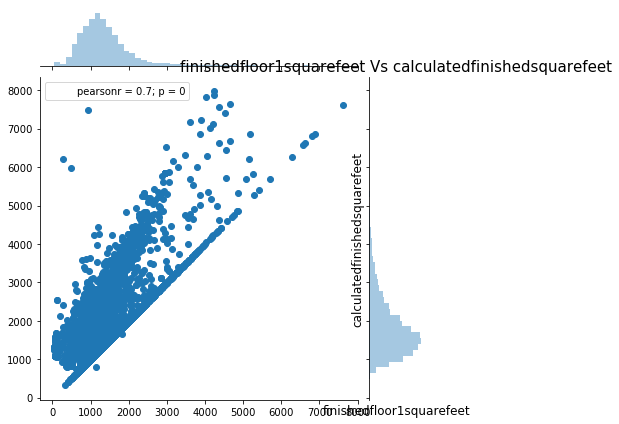

       parcelid  logerror transactiondate  airconditioningtypeid  bathroomcnt  \
46088  17052745    0.0980      2016-06-16                    1.0          2.0   
58830  17257867   -0.0377      2016-07-22                    1.0          1.0   

       bedroomcnt  buildingqualitytypeid  finishedfloor1squarefeet  \
46088         3.0                   10.0                    1821.0   
58830         2.0                    4.0                    1130.0   

       calculatedfinishedsquarefeet    fips         ...           yearbuilt  \
46088                        1654.0  6111.0         ...              1945.0   
58830                         800.0  6111.0         ...              1960.0   

       numberofstories  fireplaceflag structuretaxvaluedollarcnt  \
46088              1.0            Yes                   137697.0   
58830              1.0             No                    58000.0   

       taxvaluedollarcnt  assessmentyear  landtaxvaluedollarcnt    taxamount  \
46088           433491

In [78]:
plt.figure(figsize=(12,12))
sns.jointplot(x=df_train.finishedfloor1squarefeet.values, y=df_train.calculatedfinishedsquarefeet.values)
plt.ylabel('calculatedfinishedsquarefeet', fontsize=12)
plt.xlabel('finishedfloor1squarefeet', fontsize=12)
plt.title("finishedfloor1squarefeet Vs calculatedfinishedsquarefeet", fontsize=15)
plt.show()

#There are some properties where finishedfloor1squarefeet and calculatedfinishedsquarefeetare are both exactly the same - probably because its a studio flat of some sort so that the area on the first floor is equivalent to the total area, lets see how many there are
#For now assume if the number of stories is 1 then the finishedfloor1squarefeet is the same as calculatedfinishedsquarefeet
df_train.loc[(df_train['finishedfloor1squarefeet'].isnull()) & (df_train['numberofstories']==1),'finishedfloor1squarefeet'] = df_train.loc[(df_train['finishedfloor1squarefeet'].isnull()) & (df_train['numberofstories']==1),'calculatedfinishedsquarefeet']

#I also discovered that there seems to be two properties that have finishedfloor1squarefeet greater than calculated finishedsquarefeet. Notice also that they have big logerrors aswell - my guess is that the Zillow House price model found it difficult to predict these points due to the fact that they probably had potentially 'incorrect' data input values?
#Discussion point - should we be removing these points or leave them in as they are or 'fix' them? I think it really depends on whether the test data has similar points which may be wrong as we'll want to predict big log errors for these incorrect points aswell I guess...
#For now just remove them.
print(df_train.loc[df_train['calculatedfinishedsquarefeet']<df_train['finishedfloor1squarefeet']])
droprows = df_train.loc[df_train['calculatedfinishedsquarefeet']<df_train['finishedfloor1squarefeet']].index
df_train = df_train.drop(droprows)



In [79]:
#Let's check whats missing still
print(df_train.isnull().sum())


parcelid                            0
logerror                            0
transactiondate                     0
airconditioningtypeid               0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid               0
finishedfloor1squarefeet        74971
calculatedfinishedsquarefeet      661
fips                                0
fireplacecnt                        0
garagecarcnt                        0
garagetotalsqft                     0
hashottuborspa                      0
heatingorsystemtypeid               0
latitude                            0
longitude                           0
lotsizesquarefeet                   0
poolcnt                             0
poolsizesum                         0
pooltypeid2                         0
pooltypeid7                         0
propertycountylandusecode           0
propertylandusetypeid               0
propertyzoningdesc                  0
rawcensustractandblock              0
regionidcity

structuretaxvaluedollarcnt      1.000000
taxvaluedollarcnt               0.826052
taxamount                       0.795013
calculatedfinishedsquarefeet    0.716487
landtaxvaluedollarcnt           0.623292
bathroomcnt                     0.586639
finishedfloor1squarefeet        0.560661
bedroomcnt                      0.305401
yearbuilt                       0.297568
numberofstories                 0.222932
poolsizesum                     0.212777
poolcnt                         0.210389
pooltypeid2                     0.205170
threequarterbathnbr             0.196258
garagetotalsqft                 0.182972
pooltypeid7                     0.155389
garagecarcnt                    0.126714
fireplacecnt                    0.075147
censustractandblock             0.038538
rawcensustractandblock          0.038140
fips                            0.038011
logerror                        0.022084
lotsizesquarefeet               0.012610
regionidneighborhood            0.011340
propertyzoningde

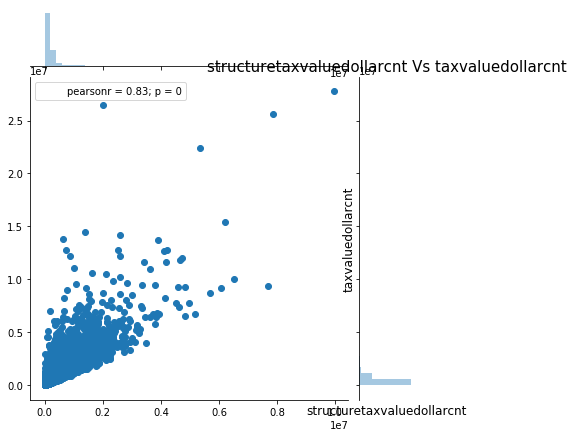

count    3.800000e+02
mean     2.918108e+05
std      5.095444e+05
min      2.200000e+01
25%      3.760475e+04
50%      1.256650e+05
75%      2.529950e+05
max      4.477220e+06
Name: taxvaluedollarcnt, dtype: float64
count    9.027300e+04
mean     4.576706e+05
std      5.548889e+05
min      2.200000e+01
25%      1.990020e+05
50%      3.428720e+05
75%      5.405890e+05
max      2.775000e+07
Name: taxvaluedollarcnt, dtype: float64
parcelid                            0
logerror                            0
transactiondate                     0
airconditioningtypeid               0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid               0
finishedfloor1squarefeet        74971
calculatedfinishedsquarefeet      661
fips                                0
fireplacecnt                        0
garagecarcnt                        0
garagetotalsqft                     0
hashottuborspa                      0
heatingorsystemtypeid               

In [80]:
#taxvaluedollarcnt & landtaxvaluedollarcnt - set it equal to the tax amount (most correlated value). Single story property so assume they are all the same
df_train.loc[df_train.taxvaluedollarcnt.isnull(),'taxvaluedollarcnt'] = df_train.loc[df_train.taxvaluedollarcnt.isnull(),'taxamount']
df_train.loc[df_train.landtaxvaluedollarcnt.isnull(),'landtaxvaluedollarcnt'] = df_train.loc[df_train.landtaxvaluedollarcnt.isnull(),'taxamount']

#structure tax value dollar - fill this in using its most correlated variable
x =  df_train.corr()
print(x.structuretaxvaluedollarcnt.sort_values(ascending = False))

#taxvaluedollarcnt is most correlated variable, let's see how they are related 
plt.figure(figsize=(12,12))
sns.jointplot(x=df_train.structuretaxvaluedollarcnt.values, y=df_train.taxvaluedollarcnt.values)
plt.ylabel('taxvaluedollarcnt', fontsize=12)
plt.xlabel('structuretaxvaluedollarcnt', fontsize=12)
plt.title("structuretaxvaluedollarcnt Vs taxvaluedollarcnt", fontsize=15)
plt.show()

#Lets look at the distribution of taxvaluedollar cnt where structuretaxvaluedollarcnt is missing just to make sure we are predicting missing values in the body of the taxvaluedollarcnt distribution
print(df_train.loc[df_train['structuretaxvaluedollarcnt'].isnull(),'taxvaluedollarcnt'].describe())
print(df_train['taxvaluedollarcnt'].describe())

#Slightly amend the k nearest neighbour function so it works on regression
def fillna_knn_reg( df, base, target, n_neighbors = 5 ):
    cols = base + [target]
    X_train = df[cols]
    scaler = StandardScaler(with_mean=True, with_std=True).fit(X_train[base].values.reshape(-1, 1))
    rescaledX = scaler.transform(X_train[base].values.reshape(-1, 1))

    X_train = rescaledX[df[target].notnull()]
    Y_train = df.loc[df[target].notnull(),target].values.reshape(-1, 1)

    knn = KNeighborsRegressor(n_neighbors, n_jobs = -1)    
    # fitting the model
    knn.fit(X_train, Y_train)
    # predict the response
    X_test = rescaledX[df[target].isnull()]
    pred = knn.predict(X_test)
    df.loc[df_train[target].isnull(),target] = pred
    return

#fill in structuretaxvaluedollarcnt using taxvaluedollarcnt as per the above
fillna_knn_reg(df = df_train, base = ['taxvaluedollarcnt'], target = 'structuretaxvaluedollarcnt')

#Do the same thing for tax amount, as taxvaluedollarcnt is its most correlated variable
fillna_knn_reg(df = df_train, base = ['taxvaluedollarcnt'], target = 'taxamount')
print(df_train.isnull().sum())

In [81]:
#Let's see whats left
df_train.isnull().sum()

parcelid                            0
logerror                            0
transactiondate                     0
airconditioningtypeid               0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid               0
finishedfloor1squarefeet        74971
calculatedfinishedsquarefeet      661
fips                                0
fireplacecnt                        0
garagecarcnt                        0
garagetotalsqft                     0
hashottuborspa                      0
heatingorsystemtypeid               0
latitude                            0
longitude                           0
lotsizesquarefeet                   0
poolcnt                             0
poolsizesum                         0
pooltypeid2                         0
pooltypeid7                         0
propertycountylandusecode           0
propertylandusetypeid               0
propertyzoningdesc                  0
rawcensustractandblock              0
regionidcity

In [82]:
catcols+=['longitude','latitude','assessmentyear']

In [83]:
def pd_change_category_by_names(data_frame,names):
    for i,col_name in enumerate(data_frame.dtypes.index):
        if col_name in names:
            data_frame[col_name] = data_frame[col_name].astype('category')
            print(col_name+" is changed to category")
            print("---------------------------------")
    print(data_frame.dtypes)

In [84]:
pd_change_category_by_names(df_train,catcols)

airconditioningtypeid is changed to category
---------------------------------
buildingqualitytypeid is changed to category
---------------------------------
fips is changed to category
---------------------------------
hashottuborspa is changed to category
---------------------------------
heatingorsystemtypeid is changed to category
---------------------------------
latitude is changed to category
---------------------------------
longitude is changed to category
---------------------------------
pooltypeid2 is changed to category
---------------------------------
pooltypeid7 is changed to category
---------------------------------
propertycountylandusecode is changed to category
---------------------------------
propertylandusetypeid is changed to category
---------------------------------
propertyzoningdesc is changed to category
---------------------------------
rawcensustractandblock is changed to category
---------------------------------
regionidcity is changed to category
----

In [85]:
new_cols=['finishedfloor1squarefeet',
'garagetotalsqft',
'lotsizesquarefeet',
'poolsizesum']

In [86]:
for i,value in enumerate(new_cols):
    print(str(i)+":"+value)
    df_train=eval("df_train.assign(new_{}=lambda x: x.{} /x.calculatedfinishedsquarefeet)".format(value,value))

0:finishedfloor1squarefeet
1:garagetotalsqft
2:lotsizesquarefeet
3:poolsizesum


In [87]:
names=list(df_train.columns)
names.remove('parcelid')
names.remove('logerror')
x_names=names
y_name='logerror'

In [88]:
import h2o
import matplotlib.pyplot as plt

In [89]:
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 hours 5 mins
H2O cluster version:,3.14.0.4
H2O cluster version age:,2 days
H2O cluster name:,H2O_from_python_ghk829_eai1ko
H2O cluster total nodes:,1
H2O cluster free memory:,6.832 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [90]:
df=h2o.H2OFrame(python_obj=df_train.to_dict("list"))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [91]:
splits=df.split_frame(ratios=[0.7])
train=splits[0]
valid=splits[1]

In [92]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
fit1 = H2ORandomForestEstimator(model_id = 'fit1',nfolds = 5)
fit1.train(x=x_names, y=y_name, training_frame=train,validation_frame=valid)
fit1.cross_validation_metrics_summary

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  fit1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.0260092008483
RMSE: 0.161273683062
MAE: 0.0717660200032
RMSLE: NaN
Mean Residual Deviance: 0.0260092008483

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.0272076940648
RMSE: 0.164947549436
MAE: 0.0711586183448
RMSLE: NaN
Mean Residual Deviance: 0.0272076940648

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.0257278866062
RMSE: 0.160399147773
MAE: 0.0706067672319
RMSLE: NaN
Mean Residual Deviance: 0.0257278866062
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,0.0706054,0.0008811,0.0694841,0.0696142,0.0727973,0.0699670,0.0711641
mean_residual_deviance,0.0257210,0.0028815,0.0231904,0.0211117,0.0331600,0.0255707,0.0255721
mse,0.0257210,0.0028815,0.0231904,0.0211117,0.0331600,0.0255707,0.0255721
r2,-0.0134412,0.0062228,-0.0007123,-0.0113629,-0.0085814,-0.0246662,-0.0218834
residual_deviance,0.0257210,0.0028815,0.0231904,0.0211117,0.0331600,0.0255707,0.0255721
rmse,0.1599005,0.0087407,0.1522838,0.1452987,0.1820988,0.1599085,0.1599127
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-10-09 11:20:52,1 min 43.446 sec,0.0,nan,nan,nan,nan,nan,nan
,2017-10-09 11:20:52,1 min 43.815 sec,1.0,0.2091904,0.0849885,0.0437606,0.2114612,0.0857597,0.0447159
,2017-10-09 11:20:53,1 min 44.222 sec,2.0,0.1991272,0.0828263,0.0396516,0.1874635,0.0812360,0.0351426
,2017-10-09 11:20:53,1 min 44.521 sec,3.0,0.1916414,0.0806845,0.0367264,0.1794816,0.0780373,0.0322137
,2017-10-09 11:20:53,1 min 45.059 sec,4.0,0.1914003,0.0812489,0.0366341,0.1763604,0.0773657,0.0311030
,2017-10-09 11:20:54,1 min 45.473 sec,5.0,0.1876533,0.0801608,0.0352138,0.1737471,0.0762519,0.0301880
,2017-10-09 11:20:54,1 min 45.937 sec,6.0,0.1881757,0.0799861,0.0354101,0.1720171,0.0755273,0.0295899
,2017-10-09 11:20:55,1 min 46.331 sec,7.0,0.1835875,0.0787821,0.0337044,0.1709549,0.0748460,0.0292256
,2017-10-09 11:20:55,1 min 46.802 sec,8.0,0.1810264,0.0782724,0.0327705,0.1700543,0.0744758,0.0289185
,2017-10-09 11:20:56,1 min 47.208 sec,9.0,0.1786974,0.0776849,0.0319327,0.1693520,0.0741455,0.0286801


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
transactiondate,2261.0666504,1.0,0.0871958
calculatedfinishedsquarefeet,1964.0109863,0.8686214,0.0757401
structuretaxvaluedollarcnt,1732.3593750,0.7661691,0.0668067
taxamount,1527.2286377,0.6754461,0.0588960
yearbuilt,1521.6387940,0.6729739,0.0586805
---,---,---,---
pooltypeid2,46.9972916,0.0207855,0.0018124
threequarterbathnbr,46.4572487,0.0205466,0.0017916
airconditioningtypeid,44.2143822,0.0195547,0.0017051
fips,42.4701309,0.0187832,0.0016378



See the whole table with table.as_data_frame()


<bound method H2ORandomForestEstimator.cross_validation_metrics_summary of >

In [93]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
fit2=H2OGradientBoostingEstimator(model_id='fit2',nfolds=5)
fit2.train(x=x_names, y=y_name, training_frame=train,validation_frame=valid)
fit2.cross_validation_metrics_summary

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  fit2


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.0239689117191
RMSE: 0.154818964339
MAE: 0.0672735414344
RMSLE: NaN
Mean Residual Deviance: 0.0239689117191

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.0268211710804
RMSE: 0.163771704151
MAE: 0.0688895731141
RMSLE: NaN
Mean Residual Deviance: 0.0268211710804

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.0252000849032
RMSE: 0.158745346084
MAE: 0.068377532972
RMSLE: NaN
Mean Residual Deviance: 0.0252000849032
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,0.0683756,0.0003569,0.0680584,0.0686649,0.0679123,0.0680071,0.0692354
mean_residual_deviance,0.0251998,0.0005093,0.0265985,0.0248167,0.0245708,0.0249064,0.0251066
mse,0.0251998,0.0005093,0.0265985,0.0248167,0.0245708,0.0249064,0.0251066
r2,0.0074187,0.0025709,0.0063750,0.0060322,0.0097806,0.0128149,0.0020909
residual_deviance,0.0251998,0.0005093,0.0265985,0.0248167,0.0245708,0.0249064,0.0251066
rmse,0.1587285,0.0015898,0.1630905,0.1575333,0.1567506,0.1578176,0.1584508
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-10-09 11:21:42,29.734 sec,0.0,0.1593353,0.0682363,0.0253877,0.1650673,0.0690364,0.0272472
,2017-10-09 11:21:42,29.871 sec,1.0,0.1590864,0.0680929,0.0253085,0.1649236,0.0689348,0.0271998
,2017-10-09 11:21:42,29.981 sec,2.0,0.1588995,0.0680109,0.0252491,0.1647440,0.0688623,0.0271406
,2017-10-09 11:21:43,30.096 sec,3.0,0.1587690,0.0679356,0.0252076,0.1646227,0.0687918,0.0271006
,2017-10-09 11:21:43,30.222 sec,4.0,0.1585760,0.0678739,0.0251463,0.1645459,0.0687634,0.0270754
---,---,---,---,---,---,---,---,---,---
,2017-10-09 11:21:45,33.012 sec,22.0,0.1568206,0.0675009,0.0245927,0.1639229,0.0687286,0.0268707
,2017-10-09 11:21:46,33.200 sec,23.0,0.1567219,0.0674989,0.0245617,0.1639208,0.0687361,0.0268700
,2017-10-09 11:21:46,33.393 sec,24.0,0.1566617,0.0674824,0.0245429,0.1639136,0.0687380,0.0268677
,2017-10-09 11:21:46,33.585 sec,25.0,0.1565176,0.0674591,0.0244977,0.1639053,0.0687427,0.0268650



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
calculatedfinishedsquarefeet,61.6125336,1.0,0.1310537
structuretaxvaluedollarcnt,47.3171463,0.7679792,0.1006465
latitude,45.4737778,0.7380605,0.0967255
taxamount,39.9013062,0.6476167,0.0848725
taxvaluedollarcnt,32.7901535,0.5321994,0.0697467
---,---,---,---
poolsizesum,0.0,0.0,0.0
threequarterbathnbr,0.0,0.0,0.0
rawcensustractandblock,0.0,0.0,0.0
pooltypeid7,0.0,0.0,0.0



See the whole table with table.as_data_frame()


<bound method H2OGradientBoostingEstimator.cross_validation_metrics_summary of >

In [94]:
from h2o.estimators.xgboost import H2OXGBoostEstimator
fit3=H2OXGBoostEstimator(model_id='fit3')
fit3.train(x=x_names, y=y_name, training_frame=train,validation_frame=valid)
fit3.cross_validation_metrics_summary

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  fit3


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.0170846269323
RMSE: 0.130708174696
MAE: 0.063515282814
RMSLE: NaN
Mean Residual Deviance: 0.0170846269323

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.0288602853156
RMSE: 0.169883151948
MAE: 0.0720907314424
RMSLE: NaN
Mean Residual Deviance: 0.0288602853156
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-10-09 11:21:49,0.092 sec,0.0,0.5137087,0.4965438,0.2638966,0.5160493,0.4976763,0.2663069
,2017-10-09 11:21:50,0.829 sec,1.0,0.3765392,0.3532905,0.1417818,0.3798726,0.3544226,0.1443032
,2017-10-09 11:21:50,1.152 sec,2.0,0.2859361,0.2548584,0.0817595,0.2908642,0.2561957,0.0846020
,2017-10-09 11:21:50,1.473 sec,3.0,0.2284970,0.1879139,0.0522109,0.2353380,0.1895545,0.0553840
,2017-10-09 11:21:51,1.785 sec,4.0,0.1939663,0.1429771,0.0376229,0.2024782,0.1447107,0.0409974
,2017-10-09 11:21:51,2.090 sec,5.0,0.1733648,0.1133644,0.0300553,0.1846060,0.1154787,0.0340794
,2017-10-09 11:21:51,2.390 sec,6.0,0.1623777,0.0944568,0.0263665,0.1749337,0.0967807,0.0306018
,2017-10-09 11:21:52,2.707 sec,7.0,0.1563391,0.0828225,0.0244419,0.1699860,0.0853066,0.0288952
,2017-10-09 11:21:52,3.002 sec,8.0,0.1520339,0.0758892,0.0231143,0.1677839,0.0786775,0.0281514
,2017-10-09 11:21:52,3.332 sec,9.0,0.1495412,0.0718180,0.0223626,0.1667084,0.0748182,0.0277917


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
regionidcity,136.0,1.0,0.0756396
structuretaxvaluedollarcnt,136.0,1.0,0.0756396
regionidzip,131.0,0.9632353,0.0728587
yearbuilt,130.0,0.9558824,0.0723026
calculatedfinishedsquarefeet,111.0,0.8161765,0.0617353
---,---,---,---
poolsizesum,4.0,0.0294118,0.0022247
fireplaceflag,3.0,0.0220588,0.0016685
hashottuborspa,3.0,0.0220588,0.0016685
pooltypeid2,2.0,0.0147059,0.0011123



See the whole table with table.as_data_frame()


<bound method H2OXGBoostEstimator.cross_validation_metrics_summary of >

In [95]:
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
fit4=H2OStackedEnsembleEstimator(model_id='fit4',base_models=[fit1.model_id,fit2.model_id])
fit4.train(x=x_names, y=y_name, training_frame=train,validation_frame=valid)
fit4.cross_validation_metrics_summary

stackedensemble Model Build progress: | (failed)


EnvironmentError: Job with key $03017f00000132d4ffffffff$_93cd5186dd508ac9ac0b752f789a4fec failed with an exception: java.lang.IllegalArgumentException: class hex.StackedEnsembleModel fit4 is already in use.  Unable to use it now.  Consider using a different destination name.
stacktrace: 
java.lang.IllegalArgumentException: class hex.StackedEnsembleModel fit4 is already in use.  Unable to use it now.  Consider using a different destination name.
	at water.Lockable$PriorWriteLock.atomic(Lockable.java:113)
	at water.Lockable$PriorWriteLock.atomic(Lockable.java:102)
	at water.TAtomic.atomic(TAtomic.java:17)
	at water.Atomic.compute2(Atomic.java:56)
	at water.Atomic.fork(Atomic.java:39)
	at water.Atomic.invoke(Atomic.java:31)
	at water.Lockable.write_lock(Lockable.java:61)
	at water.Lockable.delete_and_lock(Lockable.java:70)
	at water.Lockable.delete_and_lock(Lockable.java:68)
	at hex.ensemble.StackedEnsemble$StackedEnsembleDriver.computeImpl(StackedEnsemble.java:196)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:173)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1263)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:974)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1477)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


In [96]:
#2016년 10월 11월 12월
df_train['year'] = df_train.transactiondate.str.slice(0,4)
df_train['month'] = df_train.transactiondate.str.slice(5,7)
months=['10','11','12']
test_2016_fill=df_train.query('year=="2016" & month in @months')[['parcelid','logerror','year','month']]
test_2016_fill

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import neighbors
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import os
os.getcwd()
os.chdir('/home/ghk829/zillow')
prop_2016 = pd.read_csv('./properties_2016.csv')
train_2016 = pd.read_csv("./train_2016_v2.csv")
prop_2017 = pd.read_csv('./properties_2017.csv')
train_2017 = pd.read_csv('./train_2017.csv')

for c, dtype in zip(prop_2016.columns, prop_2016.dtypes):	
    if dtype == np.float64:		
        prop_2016[c] = prop_2016[c].astype(np.float32)
        
for c, dtype in zip(prop_2017.columns, prop_2017.dtypes):	
    if dtype == np.float64:		
        prop_2017[c] = prop_2017[c].astype(np.float32)
ref_2017=prop_2017[prop_2017.latitude.isnull()].parcelid
na_2017=prop_2016.query('parcelid in @ref_2017')
prop_2017_2=prop_2017[prop_2017.latitude.notnull()].append(na_2017)
# 2016년 데이터 기준
ref_2016=prop_2016[prop_2016.latitude.isnull()].parcelid
na_2016=prop_2017.query('parcelid in @ref_2016')
prop_2016_2=prop_2016[prop_2016.latitude.notnull()].append(na_2016)
df_train = train_2016.merge(prop_2016_2, how='left', on='parcelid')

In [19]:
df_train['year'] = df_train.transactiondate.str.slice(0,4)
df_train['month'] = df_train.transactiondate.str.slice(5,7)
df_train['day'] = df_train.transactiondate.str.slice(8,10)
df_train_fill = df_train[['parcelid','logerror','year','month']]
df_train_tmp = df_train[['parcelid','logerror','year','month','day','fips']]

In [15]:
tmp=df_train_tmp.groupby(['fips','year','month','day']).mean()
series=tmp.logerror
series

fips    year  month  day
6037.0  2016  01     01     0.011800
                     02    -0.068233
                     03     0.007131
                     04     0.005116
                     05     0.013869
                     06     0.014286
                     07    -0.003817
                     08     0.010792
                     09     0.096533
                     10    -0.015418
                     11     0.024730
                     12    -0.002409
                     13     0.037863
                     14     0.019610
                     15     0.017950
                     16     0.069500
                     17     0.019260
                     18    -0.010415
                     19     0.005936
                     20     0.015557
                     21     0.006373
                     22     0.017208
                     23     0.016925
                     24    -0.000228
                     25     0.037934
                     26     0.034339
             

In [23]:
sub=pd.read_csv('./sample_submission.csv')

0.0276

In [47]:
SP=sub.ParcelId.as_matrix()
length=df_train_fill.shape[0]
for index, parcelid in enumerate(df_train_fill.parcelid):
    if parcelid in SP:
        sub.ix[sub[sub.ParcelId==parcelid].index[0],1:7]=df_train_fill[df_train_fill.parcelid==parcelid].logerror.item()
        if index%100==0:
            print str(index*1.0/length)+'% completed'

11016594
0.0& completed
14366692
12098116
12643413
14432541
11509835
12286022
17177301
14739064
14677559
10854446
11672170
10949761
14665244
14148540
14057104
17296797
12524288
14091502
10815909
12453853
14253461
14001034
11458863
13957980
12752047
11188425
14646051
10805063
12524725
11104966
11624877
12440314
12037577
11024002
10777209
14022628
14195954
12339438
14022972
11921507
14055759
14337898
10984360
11708989
14008449
10812783
14389517
11874881
12859348
12885665
12934834
14077187
14693306
13892813
11510907
11519155
14365990
11403600
12086710
14030226
12701128
14632504
12932190
14696295
11940440
14674493
17249897
10908638
10953535
14246533
11267869
10746700
12921680


KeyboardInterrupt: 

In [46]:
sub[sub.ParcelId==11016594]

,ParcelId,201610,201611,201612,201710,201711,201712
2931667,11016594,0.0276,0.0276,0.0276,0.0276,0.0276,0.0276
